# **Weekly Project**
The goal for this week’s project is to build and train a regression model on the Capital Bike Share (Washington, D.C.) Kaggle data set, in order to predict demand for bicycle rentals at any given hour, based on time and weather, e.g.:
“Given the forecasted weather conditions, how many bicycles can we expect to be rented out (city-wide) this Saturday at 2pm?”


*  split the data into a training and test set
*   conduct an exploratory data analysis
*   train a regression model
* iteratively optimize the model by expanding or selecting 
features
* regularize the model to avoid overfitting
* calculate a RMSLE for the training and test set
* upload your code to GitHub













In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
#from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, PolynomialFeatures, FunctionTransformer
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression

In [2]:
df=pd.read_csv('train.csv', index_col=0, parse_dates=True)
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
df.tail()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129
2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88


In [4]:
df.index.resolution

'hour'

In [5]:
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   casual      10886 non-null  int64  
 9   registered  10886 non-null  int64  
 10  count       10886 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 1020.6 KB


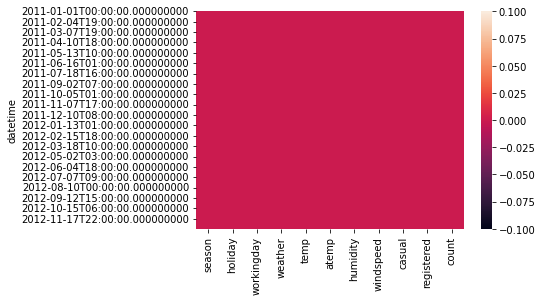

In [7]:
sns.heatmap(df.isna())

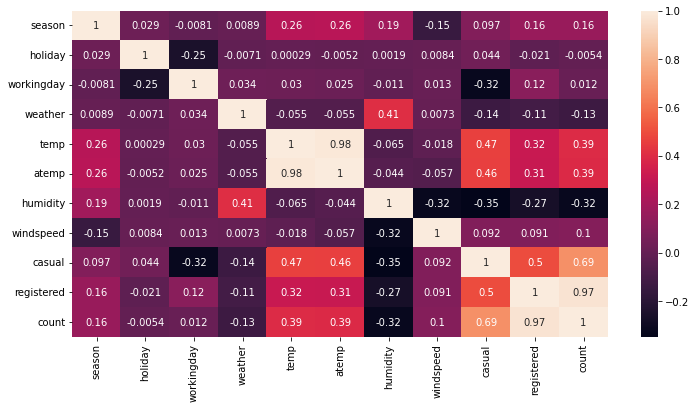

In [8]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(), annot=True)

# **EDA of data**

In [26]:
df_2=df.reset_index()
df_2.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


**Average weekly demand over one year**


Text(0, 0.5, 'Count of bike rentals')

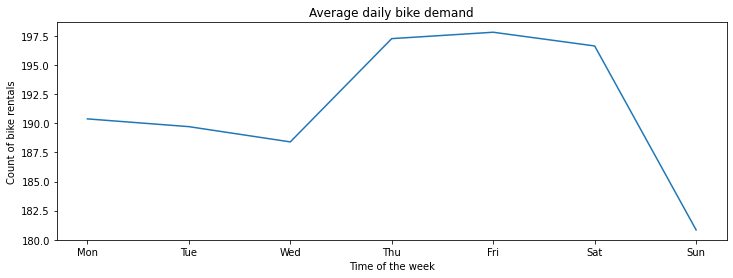

In [27]:
fig, ax = plt.subplots(figsize=(12, 4))
df_2.groupby(df_2['datetime'].dt.weekday)['count'].mean().plot(ax=ax)
ax.set_xticklabels(['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax.set_title('Average daily bike demand')
ax.set_xlabel('Time of the week')
ax.set_ylabel('Count of bike rentals')

**Average hourly demand over one year**


Text(0, 0.5, 'Count of bike rentals')

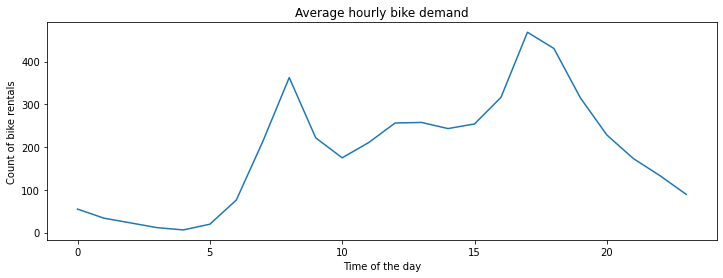

In [28]:
fig, ax = plt.subplots(figsize=(12, 4))
df_2.groupby(df_2['datetime'].dt.hour)['count'].mean().plot(ax=ax)
#ax.set_xticklabels(np.linspace(0, 24, 4))
ax.set_title('Average hourly bike demand')
ax.set_xlabel('Time of the day')
ax.set_ylabel('Count of bike rentals')

Text(0, 0.5, 'Count of bike rentals')

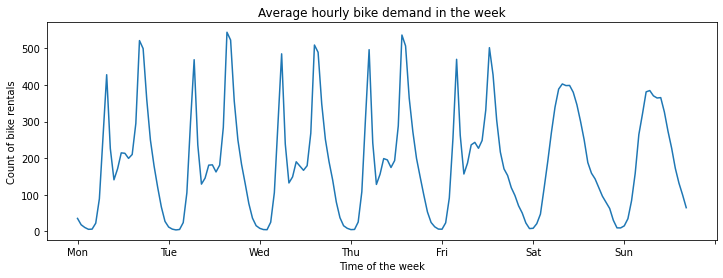

In [29]:
fig, ax = plt.subplots(figsize=(12, 4))
average_week_demand = df_2.groupby([df_2['datetime'].dt.weekday, df_2['datetime'].dt.hour]).mean()["count"]
average_week_demand.plot(ax=ax)
ax.set_xticklabels(['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax.set_title('Average hourly bike demand in the week')
ax.set_xlabel('Time of the week')
ax.set_ylabel('Count of bike rentals')


**Inspect columns to see what kind of feature engineering is needed**

In [30]:
df_2.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

In [31]:
df_2['season'].value_counts()  # season balanced

4    2734
3    2733
2    2733
1    2686
Name: season, dtype: int64

In [32]:
df_2['holiday'].value_counts()  # holiday unbalanced 

0    10575
1      311
Name: holiday, dtype: int64

In [16]:
df_2['workingday'].value_counts()  # workingday to holiday 2 to 1 ratio

1    7412
0    3474
Name: workingday, dtype: int64

In [17]:
df_2['weather'].value_counts() # category 4 can be replaced by 3 

1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64

In [18]:
df_2['weather'].replace(to_replace=4, value=3, inplace=True)
df_2['weather'].value_counts() # category 4 can be replaced by 3 

1    7192
2    2834
3     860
Name: weather, dtype: int64

In [44]:
df_2['hour'] = df_2['datetime'].dt.hour
df_2['day'] = df_2['datetime'].dt.day
df_2['month'] = df_2['datetime'].dt.month
df_2['year'] = df_2['datetime'].dt.year
df_2['weekday']=df_2['datetime'].dt.dayofweek
df_2.drop(['datetime'],axis=1, inplace=True)
df_2.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,day,month,year,weekday
0,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0,1,1,2011,5
1,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1,1,2011,5
2,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2,1,1,2011,5
3,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3,1,1,2011,5
4,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4,1,1,2011,5


In [45]:
df_2.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,day,month,year,weekday
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,11.541613,9.992559,6.521495,2011.501929,3.013963
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,6.915838,5.476608,3.444373,0.500019,2.004585
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,2011.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,6.000000,5.000000,4.000000,2011.000000,1.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,12.000000,10.000000,7.000000,2012.000000,3.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,18.000000,15.000000,10.000000,2012.000000,5.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,23.000000,19.000000,12.000000,2012.000000,6.000000


# **Split Train test**

In [46]:
y=df_2['count']
X=df_2.drop(['count'], axis=1)
X.head()
X_train, X_test, y_train, y_test =train_test_split(X,y,test_size=0.3,random_state=42)

In [47]:
X_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,hour,day,month,year,weekday
613,1,0,1,1,9.02,9.090,32,39.0007,4,172,17,8,2,2011,1
4030,3,0,0,1,22.14,25.760,68,12.9980,10,44,23,18,9,2011,6
3582,3,0,1,1,26.24,28.790,83,0.0000,1,7,4,19,8,2011,4
10101,4,0,1,1,9.02,11.365,69,8.9981,6,143,6,6,11,2012,1
1430,2,0,1,3,13.12,14.395,81,30.0026,1,18,11,5,4,2011,1


In [48]:
X_train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,hour,day,month,year,weekday
count,7620.000000,7620.000000,7620.000000,7620.000000,7620.000000,7620.000000,7620.000000,7620.000000,7620.000000,7620.000000,7620.000000,7620.000000,7620.000000,7620.000000,7620.000000
mean,2.509711,0.029265,0.683990,1.414567,20.252386,23.670368,61.893963,12.807253,35.803543,155.566798,11.493438,9.953018,6.535039,2011.502231,3.006168
std,1.117478,0.168560,0.464948,0.630354,7.824203,8.503034,19.214918,8.203174,49.716591,151.728871,6.938829,5.480905,3.442049,0.500028,1.997922
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.760000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2011.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,47.000000,7.001500,4.000000,35.000000,5.000000,5.000000,4.000000,2011.000000,1.000000
50%,3.000000,0.000000,1.000000,1.000000,20.500000,24.240000,62.000000,12.998000,16.000000,118.000000,11.000000,10.000000,7.000000,2012.000000,3.000000
75%,4.000000,0.000000,1.000000,2.000000,26.240000,31.060000,77.000000,16.997900,49.000000,223.000000,18.000000,15.000000,10.000000,2012.000000,5.000000
max,4.000000,1.000000,1.000000,4.000000,41.000000,45.455000,100.000000,56.996900,362.000000,857.000000,23.000000,19.000000,12.000000,2012.000000,6.000000


# **Feature engineering**

In [58]:
categorical_columns = ['season', 'weather']

# Transformers
categorial_transformer=OneHotEncoder(sparse=False, handle_unknown='ignore')
numeric_transformer=make_pipeline(PolynomialFeatures(5),RobustScaler())

def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [59]:
preprocessor = ColumnTransformer(
    transformers=[
        ("categorical", categorial_transformer, categorical_columns),
        ("month_sin", sin_transformer(12), ["month"]),
        ("month_cos", cos_transformer(12), ["month"]),
        ("weekday_sin", sin_transformer(7), ["weekday"]),
        ("weekday_cos", cos_transformer(7), ["weekday"]),
        ("hour_sin", sin_transformer(24), ["hour"]),
        ("hour_cos", cos_transformer(24), ["hour"]),
    ],
    remainder=numeric_transformer,
)

In [60]:
preprocessor.fit(X_train)

ColumnTransformer(remainder=Pipeline(steps=[('polynomialfeatures',
                                             PolynomialFeatures(degree=5)),
                                            ('robustscaler', RobustScaler())]),
                  transformers=[('categorical',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['season', 'weather']),
                                ('month_sin',
                                 FunctionTransformer(func=<function sin_transformer.<locals>.<lambda> at 0x7f9efd70b3b0>),
                                 ['month']),
                                ('month...
                                 FunctionTransformer(func=<function sin_transformer.<locals>.<lambda> at 0x7f9efd70bb90>),
                                 ['weekday']),
                                ('weekday_cos',
                                 FunctionTransformer(func=<func

In [61]:
# to check and see how the transformed data looks like
X_train2=pd.DataFrame(preprocessor.transform(X_train))
X_train2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2977,2978,2979,2980,2981,2982,2983,2984,2985,2986,2987,2988,2989,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999,3000,3001,3002,3003,3004,3005,3006,3007,3008,3009,3010,3011,3012,3013,3014,3015,3016
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.866025,5.000000e-01,0.781831,0.623490,-0.965926,-2.588190e-01,0.0,0.0,0.0,-0.933333,-1.052449,-1.000000,2.601206,-0.266667,0.287234,-0.2,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.206897,-0.277727,-0.242857,2.133095,...,-0.058443,-0.079053,-0.094949,-0.100789,-0.000162,-0.018116,-0.020224,-0.034918,-0.051773,-0.060277,-0.051955,-0.079685,-0.114878,-0.140678,-0.087500,-0.116933,-0.166284,-0.228927,-0.267374,0.231509,0.256370,0.275543,0.256171,0.292323,0.311585,0.168061,0.249248,0.313697,0.322367,0.020891,0.070531,0.154080,0.261364,0.286557,-0.088902,-0.118081,-0.150160,-0.180034,-0.200199,-1.0
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,-1.000000,-1.836970e-16,-0.781831,0.623490,-0.258819,9.659258e-01,0.0,0.0,-1.0,0.133333,0.105592,0.200000,0.000000,-0.133333,-0.393617,0.8,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-0.586207,-0.610999,-0.700000,-0.466726,...,0.232181,0.087953,-0.008339,-0.065569,-0.030513,-0.054243,-0.058909,-0.042232,-0.084008,-0.104107,0.171103,0.033579,-0.086585,-0.165599,1.259309,0.859338,0.487452,0.131511,-0.134041,-0.041189,-0.066551,-0.076891,-0.071402,-0.112261,-0.140883,0.098071,-0.028950,-0.156374,-0.246777,0.886912,0.579071,0.283364,-0.041667,-0.392690,2.366371,1.899532,1.486826,1.120209,0.800797,-1.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,-0.866025,-5.000000e-01,-0.433884,-0.900969,0.866025,5.000000e-01,0.0,0.0,0.0,0.466667,0.316082,0.700000,-1.300268,-0.333333,-0.590426,0.9,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.517241,0.444546,0.485714,-0.466726,...,-0.059117,-0.082582,-0.100595,-0.107078,-0.030842,-0.057997,-0.060598,-0.077399,-0.102736,-0.112658,-0.082610,-0.127398,-0.177777,-0.209108,0.060995,-0.033466,-0.143280,-0.260587,-0.334041,-0.041488,-0.069690,-0.078406,-0.101598,-0.128030,-0.148556,-0.100752,-0.162890,-0.235370,-0.285622,0.066849,-0.050313,-0.183499,-0.383614,-0.589035,3.141949,2.406435,1.802838,1.305244,0.900897,-1.0
3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,-0.500000,8.660254e-01,0.781831,0.623490,1.000000,6.123234e-17,0.0,0.0,0.0,-0.933333,-0.894408,0.233333,-0.400134,-0.222222,0.132979,-0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.206897,-0.194317,0.285714,0.133095,...,-0.058653,-0.077602,-0.090379,-0.092381,-0.008854,-0.032214,-0.025778,-0.052665,-0.063098,-0.058294,-0.068774,-0.094778,-0.118988,-0.123467,-0.098719,-0.129969,-0.175000,-0.219054,-0.222665,0.066953,0.047148,0.090788,0.013960,0.053197,0.116126,-0.026685,-0.004941,0.048514,0.134948,-0.093973,-0.101937,-0.078968,-0.006756,0.134176,-0.121949,-0.174068,-0.241174,-0.319791,-0.399203,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.866025,-5.000000e-01,0.781831,0.623490,0.258819,-9.659258e-01,0.0,0.0,0.0,-0.600000,-0.683918,0.633333,1.701072,-0.333333,-0.531915,-0.5,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.034483,-0.083226,0.457143,1.533274,...,-0.062520,-0.084371,-0.101320,-0.107078,-0.030841,-0.057991,-0.060587,-0.077453,-0.102699,-0.112536,-0.087221,-0.129786,-0.178281,-0.208003,-0.108039,-0.150296,-0.216891,-0.294682,-0.334041,-0.041485,-0.069668,-0.078365,-0.101574,-0.127796,-0.148059,-0.106117,-0.164996,-0.233766,-0.279961,-0.132485,-0.188392,-0.266172,-0.405926,-0.530662,-0.128099,-0.187501,-0.269241,-0.375070,-0.500498,-1.0


# **Feature selection**

**Lasso**

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.773e+05, tolerance: 2.509e+04
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Text(0, 0.5, 'Coefficients')

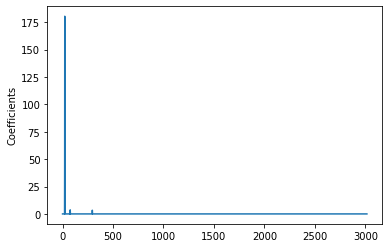

In [78]:
lasso = Lasso(alpha=0.1)
lasso.fit(X_train2, y_train)
important_features_index=pd.DataFrame({'feature': X_train2.columns, 'coefficient': np.abs(lasso.coef_)})
plt.plot(important_features_index['coefficient'])
plt.ylabel('Coefficients')


In [79]:
important_features_index.sort_values('coefficient', ascending=False, inplace=True)
important_features_index[important_features_index['coefficient']>=1]

,feature,coefficient
22,22,180.490600
21,21,44.075972
76,76,3.687992
295,295,3.371018


**Feature selected (Lasso) - New training set**

In [85]:
X_train3=X_train2[[22,21,76,295]]
X_train3.head()

,22,21,76,295
0,0.287234,-0.266667,0.287065,0.286896
1,-0.393617,-0.133333,-0.393385,-0.393153
2,-0.590426,-0.333333,-0.590077,-0.589730
3,0.132979,-0.222222,0.133278,0.133578
4,-0.531915,-0.333333,-0.531601,-0.531288


# **Train Linear Regression model**

**No Feature engineering**

In [86]:
model_LinReg=LinearRegression()

In [96]:
cross_accuracy_log = cross_val_score(model_LinReg,   
                      X_train,         
                      y_train,        
                      cv=5,          
                      scoring=make_scorer(mean_squared_error)
)

In [99]:
cross_accuracy_log.mean()

5.173734682082936e-25

**Feature engineering (Expansion)**

In [100]:
cross_accuracy_log = cross_val_score(model_LinReg,   
                      X_train2,         
                      y_train,        
                      cv=5,          
                      scoring=make_scorer(mean_squared_error)
)

In [101]:
cross_accuracy_log.mean()

33097.05574322894

**Feature engineering and Feature selection afterwards**

In [102]:
cross_accuracy_log = cross_val_score(model_LinReg,   
                      X_train3,         
                      y_train,        
                      cv=5,          
                      scoring=make_scorer(mean_squared_error)
)

In [103]:
cross_accuracy_log.mean()

1.0533596310083625e-26